In [1]:
import os
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [ ]:
path_1 = "./folder_05"
filename = "cutoff_pair.csv" 

In [3]:
#カイ二乗検定で数を減らした症状疾患ペアデータを 変数名 co_occ_pair として読み込む
os.chdir(path_1)
co_occ_pair = pd.read_csv(filename)
co_occ_pair =co_occ_pair[['symptom', 'disease', 'co_occurrence']]

In [5]:
#symptomとペアになるdisease総数
idf_n_i = co_occ_pair.groupby("symptom").count().reset_index()[["symptom", "disease"]].values.tolist()
len(idf_n_i)

384

In [6]:
#TF-IDF
tfidf_list=[]
N = co_occ_pair["disease"].nunique()  #全疾患の種類数

for pair in tqdm(co_occ_pair.values.tolist()): #co_occ_pair：共起ペアと共起数
    for symptom in idf_n_i: #idf_n_i：symptomとdisease総数
        
        if pair[0]==symptom[0]: #同じsymptomだったら
            
            #Zhou数式
            W_ij = pair[-1] #diseaseとの共起数
            n_i = symptom[1] #symptomとペアになるdisease総数
            tfidf_value = W_ij*np.log(N /n_i) 
            
            tfidf_list.append([pair[0],  pair[1], W_ij, n_i, tfidf_value])

tfidf = pd.DataFrame(tfidf_list, columns=["symptom","disease","co_occurence", "disease_num", "tf_idf"])

#disease_num：symptomとペアになるdisease総数
tfidf = tfidf.sort_values(by="tf_idf", ascending=False).reset_index(drop=True)
print(tfidf["tf_idf"].sum())

  0%|          | 0/118834 [00:00<?, ?it/s]

10308472.749203153


In [7]:
#行列の形にする
pivot_tfidf_df = tfidf.pivot(index='disease', columns='symptom', values='tf_idf').fillna(0)
print(pivot_tfidf_df.sum().sum())

10308472.749203153


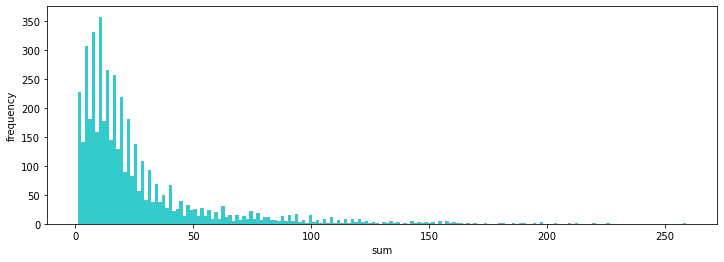

In [8]:
#疾患・症状のTFIDFがゼロより大きい値を取り出した時の可視化

plt.figure(figsize=(12,4))

#TFIDFの数
#plt.subplot(121)
each_disease_sum_vector = [sum(pivot_tfidf_df.loc[disease, :]>0) for disease in pivot_tfidf_df.index]
plt.hist(each_disease_sum_vector,color='c', bins=len(set(each_disease_sum_vector)), alpha=0.8)
plt.xlabel('sum')
plt.ylabel("frequency")
plt.show()

In [9]:
#コサイン類似度　計算

In [10]:
#コサイン算出用データフレームを作る
pre_cosine_df = tfidf.sort_values(['symptom', 'disease'])[['symptom', 'disease',"tf_idf"]].reset_index(drop=True)
pre_cosine_df = pd.pivot_table(pre_cosine_df, index='disease', columns='symptom', values="tf_idf")
pre_cosine_df = pre_cosine_df.fillna(0)#欠損値に0を入れる
#疾患個数
print(len(pre_cosine_df.index))

4716


In [11]:
#疾患ペア(直積ペア)を作る
import itertools
product_list = list(itertools.product(pre_cosine_df.index, pre_cosine_df.index))
print(len(product_list))
print(product_list[0], product_list[1])

22240656
('22q11 Deletion Syndrome', '22q11 Deletion Syndrome') ('22q11 Deletion Syndrome', '46, XX Disorders of Sex Development')


In [12]:
#tfidf行列を疾患（＝行）ごとに分けて直積ペアを作る
vectors = [each_vectors for each_vectors in np.array(pre_cosine_df)]
vectors_list = list(itertools.product(vectors, vectors))

In [13]:
#コサイン類似度

#計算式
def cosine_similarity(x, y):#xとyはベクトルの成分
    return (np.dot(x, y) / (np.sqrt(np.dot(x, x)) * np.sqrt(np.dot(y, y))))

#直積ペアにコサイン類似度計算を適用 
cosine_similarity_list = []
for disease_pair, vector in tqdm(zip( product_list, vectors_list )):
    cosine_similarity_list.append([disease_pair[0], disease_pair[-1], cosine_similarity(vector[0], vector[1])])

0it [00:00, ?it/s]

In [14]:
#データフレーム化
cosine_df = pd.DataFrame(cosine_similarity_list, columns=["disease_1", "disease_2", "cosine_similarity"])
cosine_df = cosine_df.sort_values("cosine_similarity", ascending=False).reset_index(drop=True)
pivot_cosine_df = cosine_df.pivot(index='disease_1', columns='disease_2', values='cosine_similarity')#.fillna(0)
print(len(cosine_df), len(pivot_cosine_df))

22240656 4716


In [15]:
#インデックスを取得
pivot_index = pivot_cosine_df.index.tolist()

In [16]:
#「同じ疾患同士」「順序が逆になっているだけで同じペアの片方」を削除

#アレイに変換
recent_array = np.array(pivot_cosine_df)

#下三角行列を取得する
#numpy.tril()の引数にnumpy.ndarrayを指定すると、対角線より上の成分をゼロとしたnumpy.ndarrayが返される。
#対角線のコサイン値＝１は不要なので、この対角線箇所も含めてゼロにしたい。
#numpy.tril()の第二引数のkで、境界となる対角線の位置が指定できる（正の値だと上側（右側）、負の値だと下側（左側）に移動する）

recent_array = np.tril(recent_array, k=-1) 

#データフレームにする　対角線含む上の値がゼロになっているか確認
repivot_cosine_df= pd.DataFrame(recent_array, index=pivot_cosine_df.index, columns=pivot_cosine_df.columns)


In [17]:
repivot_cosine_df[:5]

disease_2,22q11 Deletion Syndrome,"46, XX Disorders of Sex Development","46, XX Testicular Disorders of Sex Development","ACTH Syndrome, Ectopic",ACTH-Secreting Pituitary Adenoma,"AIDS Arteritis, Central Nervous System",AIDS Dementia Complex,AIDS-Associated Nephropathy,AIDS-Related Complex,AIDS-Related Opportunistic Infections,...,alpha 1-Antitrypsin Deficiency,alpha-Mannosidosis,alpha-Thalassemia,beta-Mannosidosis,beta-Thalassemia,von Hippel-Lindau Disease,"von Willebrand Disease, Type 1","von Willebrand Disease, Type 2","von Willebrand Disease, Type 3",von Willebrand Diseases
disease_1,,,,,,,,,,,,,,,,,,,,,
22q11 Deletion Syndrome,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"46, XX Disorders of Sex Development",0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"46, XX Testicular Disorders of Sex Development",0.000000,0.150058,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"ACTH Syndrome, Ectopic",0.000000,0.299644,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ACTH-Secreting Pituitary Adenoma,0.058832,0.112576,0.0,0.263595,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
#下三角行列から コサイン値ゼロ以外の値の位置を取得
recent_array_index_list = [[value_0,
                            value_1] for value_0, value_1 in zip(list(np.where(recent_array>0)[0]),
                                                                 list(np.where(recent_array>0)[1]))]
print(len(recent_array_index_list))

7804331


In [19]:
#元の（半分ゼロにする前の）行列で同じ位置を指定し、そのインデックス（疾患ペア）と値（コサイン値）を取得
#疾患a, 疾患b, abのコサイン値
repivot_pair = [ [pivot_index[i[0]],
                  pivot_index[i[1]], 
                  repivot_cosine_df.iloc[i[0], i[1]]] for i in tqdm(recent_array_index_list)]

# 作成されるデータは
#    「同じ疾患同士」「順序が逆になっただけの同じペアのうちの片方」「コサイン値ゼロ」これらを除いたデータ

  0%|          | 0/7804331 [00:00<?, ?it/s]

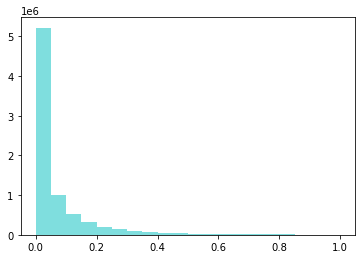

In [20]:
#コサイン値のヒストグラム
plt.hist( pd.DataFrame(repivot_pair)[2], alpha=0.5, bins=20, color='c') 
plt.show()

In [21]:
hsdn = pd.DataFrame(repivot_pair, columns=["disease_1", "disease_2", "cosine_similarity"])

In [22]:
print("疾患・症状の共起ペアの数:", len(tfidf))
print("disease_MeSHの種類数:", len(repivot_cosine_df.index))
print("symptom_MeSHの種類数:", len(idf_n_i), "\n")

疾患・症状の共起ペアの数: 118834
disease_MeSHの種類数: 4716
symptom_MeSHの種類数: 384 



In [23]:
print("ペアとなった疾患-疾患の数:", len(hsdn))
print("cos>0.1:", len(hsdn[hsdn["cosine_similarity"]>0.1]))
print("cos>0.2:", len(hsdn[hsdn["cosine_similarity"]>0.2]))
print("cos>0.5:", len(hsdn[hsdn["cosine_similarity"]>0.5]))

ペアとなった疾患-疾患の数: 7804331
cos>0.1: 1584355
cos>0.2: 736693
cos>0.5: 134057


In [24]:
print("cos>0.1を取り出したとき")
cos1 = hsdn[hsdn["cosine_similarity"]>0.1]
print("疾患-疾患ペアの数", len(cos1))
print("disease_MeSHの種類:", len(set(cos1["disease_1"].values.tolist() + cos1["disease_2"].values.tolist())))
print("cos_max:", cos1["cosine_similarity"].max())
print("cos_min:", cos1["cosine_similarity"].min(), "\n")

print("cos>0.1,cos<1を取り出したとき")
cos2 = hsdn[ (hsdn["cosine_similarity"]>0.1) & (hsdn["cosine_similarity"]<1)]
print("疾患-疾患ペアの数", len(cos2))
print("disease_MeSHの種類:", len(set(cos2["disease_1"].values.tolist() + cos2["disease_2"].values.tolist())))
print("cos_max:", cos2["cosine_similarity"].max())
print("cos_min:", cos2["cosine_similarity"].min())

cos>0.1を取り出したとき
疾患-疾患ペアの数 1584355
disease_MeSHの種類: 4714
cos_max: 1.0
cos_min: 0.10000016707885101 

cos>0.1,cos<1を取り出したとき
疾患-疾患ペアの数 1584215
disease_MeSHの種類: 4714
cos_max: 0.9999999999999999
cos_min: 0.10000016707885101


In [25]:
os.getcwd()

'/home/admin_user/デスクトップ/folder_05'

In [26]:
hsdn[:3]

,disease_1,disease_2,cosine_similarity
0,"46, XX Testicular Disorders of Sex Development","46, XX Disorders of Sex Development",0.150058
1,"ACTH Syndrome, Ectopic","46, XX Disorders of Sex Development",0.299644
2,ACTH-Secreting Pituitary Adenoma,22q11 Deletion Syndrome,0.058832


In [27]:
#保存
hsdn.to_csv("hsdn.csv", index=False)

In [28]:
# TF-IDFした後で、正のコサイン類似度を持つ疾患-疾患ペアの数は？
print(len(hsdn))

7804331


In [29]:
#networkにする
G = nx.from_pandas_edgelist( hsdn,"disease_1", "disease_2" )
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 4716
Number of edges: 7804331
Average degree: 3309.7248


ポイントの数は共起頻度数の種類数 1295


<ipython-input-30-d798651f9263>:11: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.loglog(basex=10,basey=10)
<ipython-input-30-d798651f9263>:11: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.loglog(basex=10,basey=10)


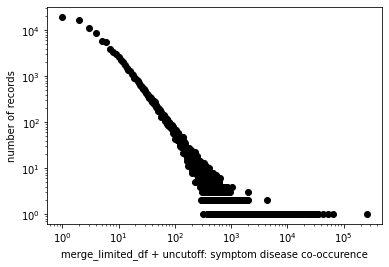

In [30]:
#一文献につき共起する数とその文献数

#両方の軸を対数スケールで設定する必要がある　loglog() 関数を使用
#loglog() 関数
#X 軸と Y 軸の両方に沿って対数スケーリングを行う時使える
#X 軸と Y 軸の対数の底は、basex パラメータと basey パラメータによって設定

a = pd.Series(co_occ_pair["co_occurrence"].value_counts())

plt.scatter(a.index, a, color="black")
plt.loglog(basex=10,basey=10)
plt.xlabel("merge_limited_df + uncutoff: symptom disease co-occurence")
plt.ylabel("number of records",)
print("ポイントの数は共起頻度数の種類数", len(a))
plt.show()

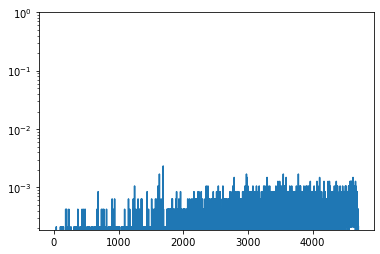

In [31]:
plt.yscale('log')
plt.plot([ degree/len(G.nodes) for degree in nx.degree_histogram(G)])
plt.yticks([0.001, 0.01, 0.1, 1])
plt.show()

In [32]:
#Zhou
#disease_MeSH数の半分の数より大きい次数を持つdisease_MeSHの数
half_d_mesh= G.number_of_nodes()/2
degree = pd.DataFrame(nx.degree(G))
large_degree = degree[degree[1] > half_d_mesh ]
print("disease_MeSH数の半分の数:", G.number_of_nodes(), "/2=", half_d_mesh)
print("disease_MeSH数の半分の数より大きい次数を持つdisease_MeSHの数:", len(large_degree))
print("その割合:", len(large_degree)/G.number_of_nodes())

disease_MeSH数の半分の数: 4716 /2= 2358.0
disease_MeSH数の半分の数より大きい次数を持つdisease_MeSHの数: 3934
その割合: 0.8341815097540288


In [33]:
#Zhou
print("最大エッジ数を持つdisease_MeSHとエッジ数:", sorted(G.degree(), key=lambda x: -x[1])[:2])
print("最小エッジ数を持つdisease_MeSHとエッジ数:", sorted(G.degree(), key=lambda x: -x[1])[-2:])

最大エッジ数を持つdisease_MeSHとエッジ数: [('Intellectual Disability', 4709), ('Hypertension', 4706)]
最小エッジ数を持つdisease_MeSHとエッジ数: [('Narcotic-Related Disorders', 35), ('Historical Trauma', 34)]


In [34]:
#Zhou
#"Hyponatremia', 'Odontoma" 
SOURCE = "Hyponatremia"
TARGET = "Odontoma"
print("'Hyponatremia'-'Odontoma'パスが存在するか:", nx.has_path(G, source=SOURCE, target=TARGET))
print("その経路, 経路長:", nx.shortest_path(G,  source=SOURCE, target=TARGET), nx.shortest_path_length(G,  source=SOURCE, target=TARGET))
print("Hyponatremia の接続疾患数", [i[1] for i in G.degree() if "Hyponatremia" in i])
print("Odontoma の接続疾患数", [i[1] for i in G.degree() if "Odontoma" in i])

'Hyponatremia'-'Odontoma'パスが存在するか: True
その経路, 経路長: ['Hyponatremia', 'Odontoma'] 1
Hyponatremia の接続疾患数 [4617]
Odontoma の接続疾患数 [2009]
